In [ ]:
# --- 1. Manipulación de Datos y BBDD ---
import pandas as pd
import numpy as np
import sqlite3

# --- 2. Visualización ---
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Interactividad y Utilidades ---
import ipywidgets as widgets
from ipywidgets import interact, fixed
import holidays 
import calendar

# --- 4. Series Temporales y Estadística ---
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# --- 5. Machine Learning (Core & Modelos) ---
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor

# --- 6. Preprocesamiento y Pipelines ---
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- 7. Validación y Métricas ---
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 8. Optimización de Hiperparámetros ---
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

# Load data

In [ ]:
conn = sqlite3.connect("data/energy_market.db")
query = """
SELECT * FROM weather_data 
INNER JOIN energy_prices USING(timestamp)
ORDER BY timestamp ASC;
"""
data = pd.read_sql(query, conn)
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True).dt.tz_convert("Europe/Madrid")
start_date = data['timestamp'].min()
end_date = data['timestamp'].max()

demand_data = pd.read_sql("SELECT * FROM energy_demand", conn, parse_dates=['timestamp'])
demand_data.columns = ['timestamp', 'demand_value'] #rename columns for clarity
demand_data['timestamp'] = pd.to_datetime(demand_data['timestamp'], utc=True).dt.tz_convert("Europe/Madrid")
# Extract hourly features (by default data is in 5 or 10 minute intervals)
hourly_features = demand_data.resample('h', on='timestamp')['demand_value'].agg([
        'min', 
        'max', 
        'mean', 
        'std', 
    ]).reset_index()
daily_features = hourly_features.add_prefix('demand_hourly_')

# Merge data to main dataframe
data = data.merge(daily_features, left_on='timestamp', right_on='demand_hourly_timestamp', how='left').drop('demand_hourly_timestamp', axis=1)

C:\Users\Juan Manuel\AppData\Local\Temp\ipykernel_19436\2709873346.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  demand_data = pd.read_sql("SELECT * FROM energy_demand", conn, parse_dates=['timestamp'])


In [3]:
def get_missing_hours(df, start_date=None, end_date=None):
    """
    Check for missing hours in a dataset. Assumes the dataframe has a 'timestamp' column with a datetime type.
    Assumes data should be hourly frequency and in the "Europe/Madrid" timezone.
    Parameters:
    - df: pandas Dataframe
    - start_date: datetime, start of the expected range. If None, uses the minimum of df
    - end_date: datetime, end of the expected range. If None, uses the maximum of df
    Returns:
    - missing_dates: pandas DatetimeIndex of missing timestamps.
    """

    if start_date is None:
        start_date = df['timestamp'].min()
    if end_date is None:
        end_date = df['timestamp'].max()

    # Create expected range
    expected_range = pd.date_range(
        start=start_date, 
        end=end_date, 
        freq='h', 
        tz="Europe/Madrid"
    )
    
    # Ensure timestamps are in the correct timezone and format
    actual_timestamps = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("Europe/Madrid")
    
    # Search for discrepancies
    missing_dates = expected_range.difference(actual_timestamps)
    
    return missing_dates

In [4]:
test_mask = (data['timestamp'].dt.month == 2)
missing_test = data[~test_mask]

In [5]:
missing_hours = get_missing_hours(missing_test)
if missing_hours.empty:
    print("All hours are present in the dataset")
else:
    print("Missing hours detected:")
    print(missing_hours)

Missing hours detected:
DatetimeIndex(['2025-02-01 00:00:00+01:00', '2025-02-01 01:00:00+01:00',
               '2025-02-01 02:00:00+01:00', '2025-02-01 03:00:00+01:00',
               '2025-02-01 04:00:00+01:00', '2025-02-01 05:00:00+01:00',
               '2025-02-01 06:00:00+01:00', '2025-02-01 07:00:00+01:00',
               '2025-02-01 08:00:00+01:00', '2025-02-01 09:00:00+01:00',
               ...
               '2025-02-28 14:00:00+01:00', '2025-02-28 15:00:00+01:00',
               '2025-02-28 16:00:00+01:00', '2025-02-28 17:00:00+01:00',
               '2025-02-28 18:00:00+01:00', '2025-02-28 19:00:00+01:00',
               '2025-02-28 20:00:00+01:00', '2025-02-28 21:00:00+01:00',
               '2025-02-28 22:00:00+01:00', '2025-02-28 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Madrid]', length=672, freq='h')


In [6]:
data.duplicated().sum()

np.int64(0)

# Ploat functions

In [7]:
def plot_price_candlestick(df, year=None, month=None, frequency='D'):
    """
    Plots a Candlestick chart using raw hourly data to calculate real OHLC.
    
    Args:
        df: The original dataframe containing the 'timestamp' and 'price' data.
        year: Year to filter (optional).
        month: Month to filter (optional). <--- ADDED
        frequency: Resampling frequency ('D' for Daily candles, 'W' for Weekly).
    """
    # 1. Filter Data on the raw dataframe
    df_working = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_working['timestamp']):
        df_working['timestamp'] = pd.to_datetime(df_working['timestamp'])

    # Apply filters if arguments are provided
    if year:
        df_working = df_working[df_working['timestamp'].dt.year == int(year)]
        
    # NEW FILTERING LOGIC
    if month:
        df_working = df_working[df_working['timestamp'].dt.month == int(month)]
        
    # Dynamic title suffix
    if month and year:
        title_suffix = f" ({month}/{year})"
    elif year:
        title_suffix = f" ({year})"
    else:
        title_suffix = " (All Time)"

    # 2. Calculate OHLC and Holiday status from raw data
    agg_ops = {
        'price': ['first', 'max', 'min', 'last'],
    }
    
    # CRITICAL: Check for holiday column and include max aggregation
    include_holiday_marker = 'is_national_holiday' in df_working.columns
    if include_holiday_marker:
        agg_ops['is_national_holiday'] = 'max'
        
    df_ohlc_full = df_working.set_index('timestamp').resample(frequency).agg(agg_ops)
    
    # Flatten column names and handle NaNs from resampling
    if include_holiday_marker:
        df_ohlc_full.columns = ['Open', 'High', 'Low', 'Close', 'is_holiday_day']
    else:
        df_ohlc_full.columns = ['Open', 'High', 'Low', 'Close']
        
    df_ohlc = df_ohlc_full.dropna()

    # 3. Create Candlestick Figure
    fig = go.Figure(data=[go.Candlestick(
        x=df_ohlc.index,
        open=df_ohlc['Open'],
        high=df_ohlc['High'],
        low=df_ohlc['Low'],
        close=df_ohlc['Close'],
        name="Price"
    )])

    # 4. Add Holiday Markers (Conditional Trace)
    if include_holiday_marker:
        df_holidays_marker = df_ohlc[df_ohlc['is_holiday_day'] == 1].reset_index()
        
        marker_y_position = df_holidays_marker['High'] * 1.01 

        fig.add_trace(go.Scatter(
            x=df_holidays_marker['timestamp'],
            y=marker_y_position,
            mode='markers',
            name='National Holiday',
            marker=dict(
                size=8,
                color='rgba(0, 150, 0, 0.8)', 
                symbol='circle'
            ),
            hovertext=df_holidays_marker['timestamp'].dt.strftime('%Y-%m-%d') + ' (Holiday)',
            hoverinfo='text',
        ))

    # 5. Layout
    fig.update_layout(
        title=f"Electricity Price Candles (Freq: {frequency}){title_suffix}",
        yaxis_title="Price (€/MWh)",
        xaxis_title="Date",
        template="plotly_white",
        xaxis_rangeslider_visible=False
    )
    
    fig.show()

In [8]:
def plot_correlation(df, variable_x):
    # Generamos el gráfico usando la variable que nos pasen
    fig = px.scatter(
        df, 
        x=variable_x, 
        y="price", 
        opacity=0.5, 
        title=f"Análisis de Correlación: {variable_x} vs Precio",
        trendline="ols", # Línea de tendencia
        color="price", 
        color_continuous_scale="Plasma",
        height=600 # Altura fija para que no 'baile' al cambiar
    )
    fig.show()


In [9]:
def plot_dual_prices(df, variable_y, year=None, month=None):
    """
    Plots Price vs a secondary variable with optional filtering by year and month.
    """
    # Create a copy to avoid modifying the original dataframe
    df_to_plot = df.copy()
    
    # Ensure timestamp is in datetime format
    df_to_plot['timestamp'] = pd.to_datetime(df_to_plot['timestamp'])

    # Apply filters if arguments are provided
    if year:
        df_to_plot = df_to_plot[df_to_plot['timestamp'].dt.year == int(year)]
    
    if month:
        df_to_plot = df_to_plot[df_to_plot['timestamp'].dt.month == int(month)]

    # Create a figure with secondary Y-axis
    fig_dual = make_subplots(specs=[[{"secondary_y": True}]])

    # Trace 1: Price (Primary Y)
    fig_dual.add_trace(
        go.Scatter(
            x=df_to_plot['timestamp'], 
            y=df_to_plot['price'], 
            name="Price (€)", 
            line=dict(color="#2c64ff", dash='dot')
        ),
        secondary_y=False,
    )

    # Trace 2: Variable Y (Secondary Y)
    fig_dual.add_trace(
        go.Scatter(
            x=df_to_plot['timestamp'], 
            y=df_to_plot[variable_y], 
            name=variable_y, 
            line=dict(color="#b92929", dash='dot')
        ),
        secondary_y=True,
    )

    # Layout details with dynamic title
    title_suffix = f" ({month}/{year})" if month and year else f" ({year})" if year else ""
    
    fig_dual.update_layout(title_text=f"Market Dynamics: Price vs {variable_y}{title_suffix}")
    fig_dual.update_yaxes(title_text="Price (€/MWh)", secondary_y=False)
    fig_dual.update_yaxes(title_text=variable_y, secondary_y=True)

    fig_dual.show()


In [10]:
# Params to plot
years = [None] + list(range(start_date.year, end_date.year + 1))
months = [None] + list(range(1,13))
freqs = ['D', 'W', 'ME']

# Create features

## Date features

In [11]:
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['dow'] = data['timestamp'].dt.dayofweek
data['woy'] = data['timestamp'].dt.isocalendar().week
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour
data['is_weekend'] = data['dow'].isin([5,6]).astype(int)

# Add COVID-19 lockdown indicator (Spain)
covid_start = "2020-03-14"
loockdown_finish = "2020-06-21"
covid_end = "2021-05-09"

data['is_covid'] = data['timestamp'].between(covid_start, covid_end, inclusive='both').astype(int)
# Actually this is not needed as there is no data in this range, but to be consistent:
data['is_covid_lockdown'] = data['timestamp'].between(covid_start, loockdown_finish, inclusive='both').astype(int)

## Holidays features

In [12]:
def add_national_holidays(df, country_code='ES'):
    """
    Adds a binary feature 'is_national_holiday' using the holidays library.
    Automatically detects years present in the dataframe.
    """
    unique_years = df['timestamp'].dt.year.unique()
    es_holidays = holidays.country_holidays(country_code, years=unique_years)
    
    temp_dates = df['timestamp'].dt.date
    df['is_national_holiday'] = temp_dates.isin(es_holidays).astype(int)
    df['holiday_name'] = temp_dates.map(es_holidays)
    df['holiday_name'] = df['holiday_name'].fillna("Not Holiday")
    
    return df

In [13]:
data = add_national_holidays(data)

## Create lags features

In [14]:
def make_lags(ts, lags, shift_step=0, prefix = None):
    if prefix is None: prefix = ts.name
    ts_shifted = ts.shift(shift_step)
    return pd.concat({
        f'{prefix}_lag_{i}_sh{shift_step}': ts_shifted.shift(i)
        for i in lags
    }, axis=1)

def make_diffs(ts, diffs, shift_step=0, prefix=None):
    """
    Calculates differences based on SHIFTED data to avoid leakage.
    Logic: (Value at t-shift) - (Value at t-shift-diff)
    """
    ts_safe = ts.shift(shift_step)
    
    return pd.concat({
        f'{prefix}_diff_{i}_shifted_{shift_step}': ts_safe.diff(i)
        for i in diffs
    }, axis=1)

def make_rollings(ts, windows, shift_step=1, prefix=None):
    """
    Calculates EWM/Rolling stats on SHIFTED data.
    shift_step: 
       - Use 1 for Recursive models (Day-ahead) or Weather Forecasts.
       - Use 336 for Direct models (14-day horizon) on Endogenous vars.
    """
    ts_shifted = ts.shift(shift_step)
    
    if prefix is None: prefix = ''
    features = {}

    for i in windows:
        features[f'{prefix}_exp_roll_{i}_mean_sh{shift_step}'] = ts_shifted.ewm(span=i, adjust=False).mean()
        features[f'{prefix}_roll_{i}_median_sh{shift_step}'] = ts_shifted.rolling(window=i).median()
        features[f'{prefix}_roll_{i}_std_sh{shift_step}'] = ts_shifted.rolling(window=i).std()

    return pd.concat(features, axis=1)

In [15]:
base_lags = [0, 1, 8, 16, 24, 48, 72, 168, 336] #168= 7*24, 336 = 14*24
base_windows = [24, 168, 336] #4 weeks = 672 hours
weather_horizont = 1
price_horizont = 1 # Horizont to prevent data leakage during forecast

weather_cols = ['temperature_2m', 'wind_speed_100m', 'solar_radiation']

price_cols = ['demand_hourly_min', 'demand_hourly_max', 'demand_hourly_mean',
       'demand_hourly_std', 'price']

### Add time series features

In [16]:
data_lags = []


for col in weather_cols:
    data_lags.append(make_lags(data[col], lags=base_lags, shift_step=weather_horizont, prefix=col))
    data_lags.append(make_diffs(data[col], diffs=base_lags, shift_step=weather_horizont, prefix=col))
    data_lags.append(make_rollings(data[col], windows=base_windows, shift_step=weather_horizont, prefix=col))

for col in price_cols:
    data_lags.append(make_lags(data[col], lags=base_lags, shift_step=price_horizont, prefix=col))
    data_lags.append(make_diffs(data[col], diffs=base_lags, shift_step=price_horizont, prefix=col))
    data_lags.append(make_rollings(data[col], windows=base_windows, shift_step=price_horizont, prefix=col))

all_data_lags = pd.concat(data_lags, axis=1)
all_data = pd.concat([data, all_data_lags], axis=1)
all_data = all_data.dropna() # handle missing values when there is no past.
all_data.head()

,timestamp,temperature_2m,wind_speed_100m,solar_radiation,cloud_cover,rain,price,demand_hourly_min,demand_hourly_max,demand_hourly_mean,...,price_diff_336_shifted_1,price_exp_roll_24_mean_sh1,price_roll_24_median_sh1,price_roll_24_std_sh1,price_exp_roll_168_mean_sh1,price_roll_168_median_sh1,price_roll_168_std_sh1,price_exp_roll_336_mean_sh1,price_roll_336_median_sh1,price_roll_336_std_sh1
337,2025-01-14 01:00:00+01:00,0.298,1.252996,0.0,0.0,0.0,103.70,24484.0,25891.0,25404.250000,...,45.89,124.714773,118.715,29.829586,105.727923,108.715,33.698666,98.158842,105.645,40.685429
338,2025-01-14 02:00:00+01:00,-0.302,1.000000,0.0,0.0,0.0,114.53,23885.0,24767.0,24310.833333,...,-35.33,123.033591,118.715,29.875144,105.703924,108.715,32.881499,98.191727,105.415,40.624225
339,2025-01-14 03:00:00+01:00,-0.752,1.392839,0.0,0.0,0.0,112.03,23540.0,24213.0,23824.750000,...,-22.95,122.353304,118.715,29.611601,105.808375,108.900,32.072082,98.288690,105.415,40.576439
340,2025-01-14 04:00:00+01:00,-1.202,1.200000,0.0,14.0,0.0,112.21,23511.0,23941.0,23673.333333,...,54.97,121.527440,118.715,29.238578,105.882003,109.200,31.657978,98.370241,105.645,40.523074
341,2025-01-14 05:00:00+01:00,-1.502,1.264911,0.0,20.0,0.0,114.34,23848.0,25088.0,24451.833333,...,-15.16,120.782044,118.715,28.831885,105.956891,109.705,30.598723,98.452376,105.645,40.498500


Now a new feature that indicates how the price changes in each time period will be introduced.

In [17]:
def add_tariff_period_vectorized(df):
    """
    Adds tariff periods using vectorized operations (zero loops).
    Handles the structural break of June 1st, 2021 (2.0TD).
    """
    df = df.copy() #copy to avoid changing the original
    
    ts = df['timestamp']
    hour = df['hour']
    month = df['month']

    is_weekend_or_holiday = (df['is_weekend'] == 1) | (df['is_national_holiday'] == 1)

    # Structure break June 1st
    DATE_CHANGE = pd.Timestamp("2021-06-01", tz=ts.dt.tz)
    mask_new_system = ts >= DATE_CHANGE
    mask_old_system = ~mask_new_system

    # ---------------------------------------------------------
    # 2.0TD - After June 2021
    # ---------------------------------------------------------

    cond_p3 = is_weekend_or_holiday | (hour < 8)

    cond_p2 = (
        ((hour >= 8) & (hour < 10)) | 
        ((hour >= 14) & (hour < 18)) | 
        ((hour >= 22) & (hour < 24))
    ) & (~is_weekend_or_holiday) # Exclude weekends and holidays

    df.loc[mask_new_system, 'tariff_period'] = np.select(
        [cond_p3[mask_new_system], cond_p2[mask_new_system]], 
        ['P3_Valle', 'P2_Llano'], 
        default='P1_Punta'
    )

    # ---------------------------------------------------------
    # 2.0 DHA - Before June 2021
    # ---------------------------------------------------------
    
    if mask_old_system.any(): # Only if old data 
        # seasons aprox
        is_summer = (month > 3) & (month < 10)
        is_winter = ~is_summer
        
        punta_summer = is_summer & (hour >= 13) & (hour < 23)
        punta_winter = is_winter & (hour >= 12) & (hour < 22)

        is_old_punta = punta_summer | punta_winter
        
        df.loc[mask_old_system, 'tariff_period'] = np.where(
            is_old_punta[mask_old_system], 
            'Old_Punta', 
            'Old_Valle'
        )

    return df

In [18]:
all_data = add_tariff_period_vectorized(all_data)

The demand for energy by itself is not a good price indicator. We need to introduce how much solar and wind generation can achieve to cover the total demand. Fewer generations means that more energy from other sources (like gas) is needed, resulting in higher prices. However, we do not have the renewable generations, (we can unload it from ESIOS, but it is supposed that it cannot be accessed for educational purposes), so we need to aproximate them.

In [19]:
all_data['renewable_potential_proxy'] = (all_data['solar_radiation'] / all_data['solar_radiation'].max()) + \
                                        (all_data['wind_speed_100m'] / all_data['wind_speed_100m'].max())

all_data['net_load_proxy'] = all_data['demand_hourly_mean'] / (1 + all_data['renewable_potential_proxy'])
# 0 renewable_potential_proxy means that all demand is from other sources. Higher net_load_proxy values should means fewer prices values

# Plots

### Plots daily price and net_load distribution

In [20]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Box(
        x=all_data['dow'],
        y=all_data['price'],
        name="Price",
        marker_color="#c0392b",
        offsetgroup='A',  # Group A pushes box to the left
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Box(
        x=all_data['dow'],
        y=all_data['net_load_proxy'],
        name="Net Load Proxy",
        marker_color="#2980b9",
        offsetgroup='B', # Group B pushes box to the right
    ),
    secondary_y=True,
)

# 4. Layout Adjustments
fig.update_layout(
    title_text="Price vs Net Load Distribution by Day of Week",
    boxmode='group', # tells plotly to group boxes side-by-side
    xaxis=dict(
        tickmode='array',
        tickvals=[0,1,2,3,4,5,6],
        ticktext=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
        title="Day of Week"
    )
)

# Set y-axes titles
fig.update_yaxes(title_text="Price (€/MWh)", secondary_y=False)
fig.update_yaxes(title_text="Net Load Proxy", secondary_y=True)

fig.show()

In [21]:
fig.update_layout(
    width=1000,
    height=600,
    # A veces la fuente predeterminada causa problemas en el motor headless
    font=dict(family="Arial") 
)

# 2. Guarda SIN argumentos extra (quita el scale por ahora)
# Forzamos el uso del motor nuevo para que no busque Kaleido
fig.write_image("BoxPlot.png", width=1200, height=800, scale=3, engine="kaleido")

C:\Users\Juan Manuel\AppData\Local\Temp\ipykernel_19436\1834833973.py:10: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




In [22]:
interact(plot_dual_prices, df=fixed(all_data), variable_y=fixed('net_load_proxy'), year=years, month=months)

interactive(children=(Dropdown(description='year', options=(None, 2024, 2025), value=None), Dropdown(descripti…

<function __main__.plot_dual_prices(df, variable_y, year=None, month=None)>

The plots before shows a strong correlaction between price and net_load_proxy. Let's formally validate this relationship using a linear regression hypothesis test (Ordinary Least Squares - OLS).

In [23]:
def run_ols_test(df, y_col, x_col):
    """
    Performs an OLS regression test on the relationship between Y and X.
    The p-value confirms or rejects the null hypothesis (H0: no relationship).
    """
    Y = df[y_col]
    X = df[[x_col]]
    
    # Add intercept
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Show summary of the test
    print(results.summary())

    p_value = results.pvalues[x_col]
    
    # Treshold = 0.05
    alpha = 0.05
    if p_value < alpha:
        conclusion = f"RECHAZAMOS H0. La correlación es estadísticamente significativa. p valor = {p_value:.5e}"
    else:
        conclusion = f"NO PODEMOS RECHAZAR H0. La correlación no es significativa.p valor = {p_value:.5e}"
        
    return conclusion


In [24]:
run_ols_test(all_data, 'price', 'net_load_proxy')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     4256.
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:20:47   Log-Likelihood:                -41972.
No. Observations:                8204   AIC:                         8.395e+04
Df Residuals:                    8202   BIC:                         8.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -45.0933      1.898    -23.

'RECHAZAMOS H0. La correlación es estadísticamente significativa. p valor = 0.00000e+00'

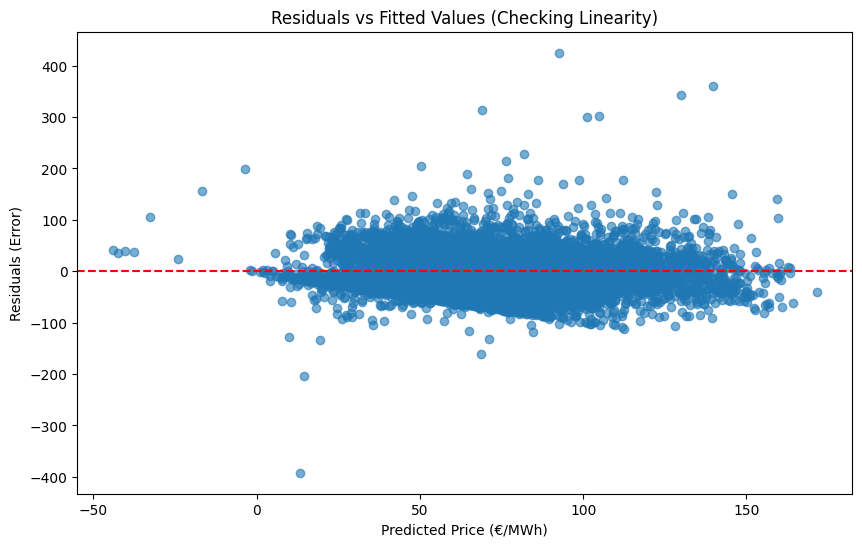

In [25]:
X = sm.add_constant(all_data[['net_load_proxy']])
Y = all_data['price']
results = sm.OLS(Y, X, missing='drop').fit()

# Plot: Residuals vs Fitted values
plt.figure(figsize=(10, 6))
# Gráfico de dispersión de los errores (residuales) contra los valores predichos
plt.scatter(results.fittedvalues, results.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values (Checking Linearity)')
plt.xlabel('Predicted Price (€/MWh)')
plt.ylabel('Residuals (Error)')
plt.show()

A strong suscess. Knowing net_load_proxy will help us make more accurate predictions. However, the plot from the above show that there might be a non linear correlation. This information will help us in selecting the model

## Now let's check temporal analisis

In [26]:
hourly_profile = all_data.groupby('hour')['price'].mean().reset_index()
dow_profile = all_data.groupby('dow')['price'].mean().reset_index()
daily_profile = all_data.groupby('day')['price'].mean().reset_index()

In [27]:
fig = px.line(
    hourly_profile, 
    x='hour', 
    y='price', 
    title="Precio Promedio por Hora del Día",
    markers=True
)
fig.update_xaxes(tickmode='linear', dtick=1, range=[0, 23])
fig.show()
fig = px.line(
    dow_profile, 
    x='dow', 
    y='price', 
    title="Precio Promedio por dia de la semana",
    markers=True
)
fig.update_xaxes(tickmode='linear', dtick=1, range=[0, 6])
fig.show()

fig = px.line(
    daily_profile, 
    x='day', 
    y='price', 
    title="Precio Promedio por dia del mes",
    markers=True
)
fig.update_xaxes(tickmode='linear', dtick=1, range=[1, 31])
fig.show()

In [28]:
profile_monthly = data.groupby('month')['price'].mean().reset_index()
color_range = [50, profile_monthly['price'].max()]
fig = px.bar(
    profile_monthly,
    x='month',
    y='price',
    title='Title',
    color='price',
    color_continuous_scale='Plasma',
    range_color=color_range,
)
fig.show()

## Autocorrelation of shifts and lags

In [29]:
lag_cols = [col for col in all_data.columns if ('price_lag' in col or 'price' == col)]

lag_corr = all_data[lag_cols].corr()

fig = px.imshow(
    lag_corr.loc[['price']],
    text_auto=".2f",
    aspect="auto",
    title="Autocorrelación de Precio vs Lags",
    color_continuous_scale="RdBu_r"
)
fig.show()

### Check tariff period variability

In [30]:
fig = px.box(
    all_data,
    x='tariff_period',
    y='price',
    title='Distribución Horaria del Precio Segmentada por Tarifa (Punta/Valle)',
    labels={'price': 'Precio (€/MWh)', 'hour': 'Hora del Día'},
    height=600
)

fig.update_layout(
        font=dict(family="Arial"),
        showlegend=False # Legend is redundant if x-axis is labeled
    )

fig.update_xaxes(tickmode='linear', dtick=1) 
fig.show()

In [31]:
interact(plot_price_candlestick, df=fixed(all_data), year=years, month=months, frequency=freqs)

interactive(children=(Dropdown(description='year', options=(None, 2024, 2025), value=None), Dropdown(descripti…

<function __main__.plot_price_candlestick(df, year=None, month=None, frequency='D')>

# Model creation

# Split train and test

In [32]:
split_date = '2024-01-01'

train = all_data[all_data['timestamp'] < split_date].copy()
test = all_data[all_data['timestamp'] >= split_date].copy()

print(f"Train dates: {train['timestamp'].min()} to {train['timestamp'].max()}")
print(f"Test dates:  {test['timestamp'].min()} to {test['timestamp'].max()}")

Train dates: NaT to NaT
Test dates:  2025-01-14 01:00:00+01:00 to 2025-12-21 20:00:00+01:00


# Define strategies

## Direct strat

In [33]:
def create_direct_targets(series, horizon=24):
    "f""Creates the multi-output target matrix Y."""
    targets = {}
    for h in range(1, horizon + 1):
        targets[f'y_t+{h}'] = series.shift(-h)
    return pd.concat(targets, axis=1)

X_train = train.drop(['timestamp', 'price'], axis=1)
train_index = train.index

y_train_direct = create_direct_targets(train['price'])

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
X_train[cat_cols] = X_train[cat_cols].astype('category')

# Deterministic process
ts = pd.PeriodIndex(all_data['timestamp'], freq='h')
fourier = CalendarFourier(freq="YE", order=8)            
dp_fourier = DeterministicProcess(
            index = ts,
            constant=False,             
            order=1,             
            seasonal=True,                                    
            additional_terms=[fourier],     
            drop=True
)
X_fourier = dp_fourier.in_sample().reset_index().drop('timestamp', axis=1)
X_fourier.index = all_data.index

X_train_fourier = X_fourier.loc[train.index]
X_test_fourier = X_fourier.loc[test.index]

X_train = pd.concat([X_train, X_fourier], axis=1)

## Model

In [34]:
class StackedDirect(BaseEstimator, RegressorMixin):
    
    def __init__(self, cols_m1, cat_cols=None, model_1=None, model_2=None, prefix='M1_Pred', n_splits=5):
        self.cols_m1 = cols_m1
        self.cat_cols = cat_cols
        self.prefix = prefix
        self.y_columns = None
        self.n_splits = n_splits
        
        self.model_1 = model_1 if model_1 else make_pipeline(StandardScaler(), Ridge(alpha=1.0))
        
        if model_2:
            self.model_2 = model_2
        else:
            if cat_cols is None:
                raise ValueError("Configuration Error: 'cat_cols' must be provided if 'model_2' is not defined.")
            
            self.model_2 = CatBoostRegressor(
                loss_function='MultiRMSE',
                task_type="GPU",
                devices='0',
                verbose=0,
                boosting_type='Plain',
                cat_features=cat_cols.tolist()
            )

    def fit(self, X, y):
        X_1 = X[self.cols_m1].copy()
        X_2 = X.copy()
        self.y_columns = y.columns
        
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        meta_features_list = []
        
        # Generate meta-features (Out-Of-Fold)
        for train_index, test_index in tscv.split(X_1):
            X_train_fold, X_test_fold = X_1.iloc[train_index], X_1.iloc[test_index]
            y_train_fold = y.iloc[train_index]
            
            self.model_1.fit(X_train_fold, y_train_fold)
            preds_fold = self.model_1.predict(X_test_fold)
            
            preds_df = pd.DataFrame(
                preds_fold,
                index=X_test_fold.index,
                columns=[f'{self.prefix}_{c}' for c in y.columns]
            )
            meta_features_list.append(preds_df)

        y_fit = pd.concat(meta_features_list)
        
        # Align data (remove initial training gap)
        X_2_trimmed = X_2.loc[y_fit.index]
        y_trimmed = y.loc[y_fit.index]
        
        X_2_augm = pd.concat([X_2_trimmed, y_fit], axis=1)
        
        # Final training
        self.model_2.fit(X_2_augm, y_trimmed)
        self.model_1.fit(X_1, y)
        
        return self
    
    def predict(self, X):
        X_1 = X[self.cols_m1].copy()
        X_2 = X.copy()
        
        y_pred_m1 = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=[f'{self.prefix}_{c}' for c in self.y_columns]
        )
        
        X_2_augm = pd.concat([X_2, y_pred_m1], axis=1)
        y_pred_m2_arr = self.model_2.predict(X_2_augm)
        
        return pd.DataFrame(
            y_pred_m2_arr,
            index=X_2_augm.index,
            columns=self.y_columns
        )
    
cb_model = CatBoostRegressor(
    loss_function='MultiRMSE',
    task_type="GPU",
    devices='0',
    verbose=0,
    boosting_type='Plain',
    cat_features=cat_cols.tolist()
)
ridge_scaled = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

direct_model = StackedDirect(model_1=ridge_scaled, model_2=cb_model, cols_m1=X_fourier.columns)

## Validation

In [35]:
y_train_direct_clean = y_train_direct.dropna(how='any')
X_train_aligned = X_train.loc[y_train_direct_clean.index]

In [36]:
# 1. Entrenar el modelo con TODO el set de entrenamiento (sin splits, a por todas)
print("⚙️ Entrenando modelo con datos históricos (2021-2023)...")
# Nota: Si usaste OptunaSearchCV, cambia 'direct_model' por 'optuna_search.best_estimator_'
direct_model.fit(X_train_aligned, y_train_direct_clean) 

⚙️ Entrenando modelo con datos históricos (2021-2023)...


ValueError: Cannot have number of folds=6 greater than the number of samples=0.

In [ ]:
# 2. Preparar los datos de 2024 (TEST) replicando la ingeniería de features
print("📅 Generando predicciones para 2024...")

# A) Features base
X_test_2024 = test.drop(['timestamp', 'price'], axis=1, errors='ignore')

# B) Añadir Fourier (Crucial: Usar el índice para alinear)
X_test_2024 = pd.concat([X_test_2024, X_test_fourier.loc[test.index]], axis=1)

# C) Asegurar tipos categóricos
cat_cols_test = [c for c in cat_cols if c in X_test_2024.columns]
X_test_2024[cat_cols_test] = X_test_2024[cat_cols_test].astype('category')

# D) Crear Targets Reales 2024 (para calcular el error)
y_test_direct = create_direct_targets(test['price'])

# 3. Limpieza y Alineación Final
# Eliminamos las últimas 24h donde no tenemos target futuro
y_test_clean = y_test_direct.dropna()
X_test_aligned_2024 = X_test_2024.loc[y_test_clean.index]

# Limpieza de seguridad (borrar timestamp si se coló)
if 'timestamp' in X_test_aligned_2024.columns: 
    X_test_aligned_2024 = X_test_aligned_2024.drop('timestamp', axis=1)

# 4. Predecir 2024
preds_2024 = direct_model.predict(X_test_aligned_2024)

# 5. Resultados y Gráfica
# Calculamos MAE Global (promedio de las 24 horas predichas)
mae_global = mean_absolute_error(y_test_clean, preds_2024)
rmse_global = np.sqrt(mean_squared_error(y_test_clean, preds_2024))

# Para graficar, cogemos solo la predicción a t+1 (siguiente hora)
y_real_plot = y_test_clean.iloc[:, 0]
y_pred_plot = preds_2024.iloc[:, 0]

print(f"✅ ¡Hecho! MAE Global en 2024: {mae_global:.2f} €/MWh")
print(f"✅ ¡Hecho! RMSE Global en 2024: {rmse_global:.2f} €/MWh")

# Visualización
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_real_plot.index, y=y_real_plot, name='Precio Real 2024', 
                         line=dict(color='black', width=1), opacity=0.7))
fig.add_trace(go.Scatter(x=y_pred_plot.index, y=y_pred_plot, name='Predicción Modelo', 
                         line=dict(color='#ff2c2c', width=1.5)))

fig.update_layout(
    title=f"Resultados Test 2024 | Error Medio (MAE): {mae_global:.2f} €/MWh",
    xaxis_title="Fecha",
    yaxis_title="Precio (€/MWh)",
    template="plotly_white",
    height=600
)
fig.show()

📅 Generando predicciones para 2024...
✅ ¡Hecho! MAE Global en 2024: 26.83 €/MWh
✅ ¡Hecho! RMSE Global en 2024: 36.96 €/MWh


## Dummy model to compare

In [ ]:
y_true = test['price']
y_pred_dummy = test['price'].shift(24)

# Align
valid_mask = y_true.notna() & y_pred_dummy.notna()
y_true_aligned = y_true[valid_mask]
y_dummy_aligned = y_pred_dummy[valid_mask]

# Metrics
rmse_dummy = np.sqrt(mean_squared_error(y_true_aligned, y_dummy_aligned))
mae_dummy = mean_absolute_error(y_true_aligned, y_dummy_aligned)

print(f"--- Benchmark: Seasonal Naive ---")
print(f"RMSE Dummy: {rmse_dummy:.4f} €/MWh")
print(f"MAE Dummy:  {mae_dummy:.4f} €/MWh")

--- Benchmark: Seasonal Naive ---
RMSE Dummy: 41.8897 €/MWh
MAE Dummy:  29.2241 €/MWh


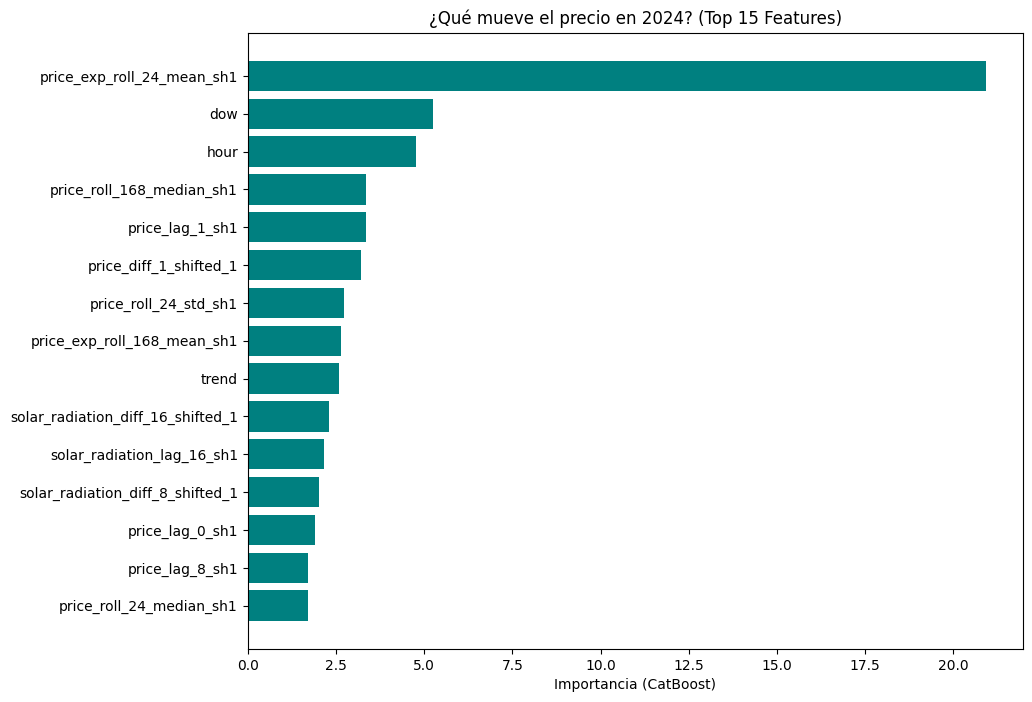

In [ ]:
import matplotlib.pyplot as plt

# Extraer el modelo CatBoost del wrapper (asumiendo que usaste optuna search)
# Si best_model es el StackedDirect, accedemos a model_2
final_cb = direct_model.model_2 

# Obtener importancia
importance = final_cb.get_feature_importance(type='FeatureImportance')
# Nombres: Tenemos que reconstruir los nombres porque X_2_augm se crea al vuelo
# Son las columnas de X_train_aligned + las predicciones de Ridge
feature_names = X_train_aligned.columns.tolist() + [f'M1_Pred_{c}' for c in y_train_direct.columns]

# Crear DataFrame y Graficar Top 15
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
fi_df = fi_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'], fi_df['importance'], color='teal')
plt.xlabel("Importancia (CatBoost)")
plt.title("¿Qué mueve el precio en 2024? (Top 15 Features)")
plt.gca().invert_yaxis() # La más importante arriba
plt.show()